# Answering Business Questions using SQL
<br/><br/>
### Project Objective:

In this project, we'll work with SQLite sample database named chinook, which represents a digital media store, including tables for artists, albums, media tracks, invoices, etc.. in total 11 tables.

In [1]:
# importing required libaries
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# create 3 helper functions
# create fucntion that takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# create fucntion that takes function that takes a SQL command as an argument and executes it using the sqlite module    
def run_command(c):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

# create fucntion that calls the run_query() function to return a list of all tables and views in the database        
def show_tables():
    q = '''SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view")'''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


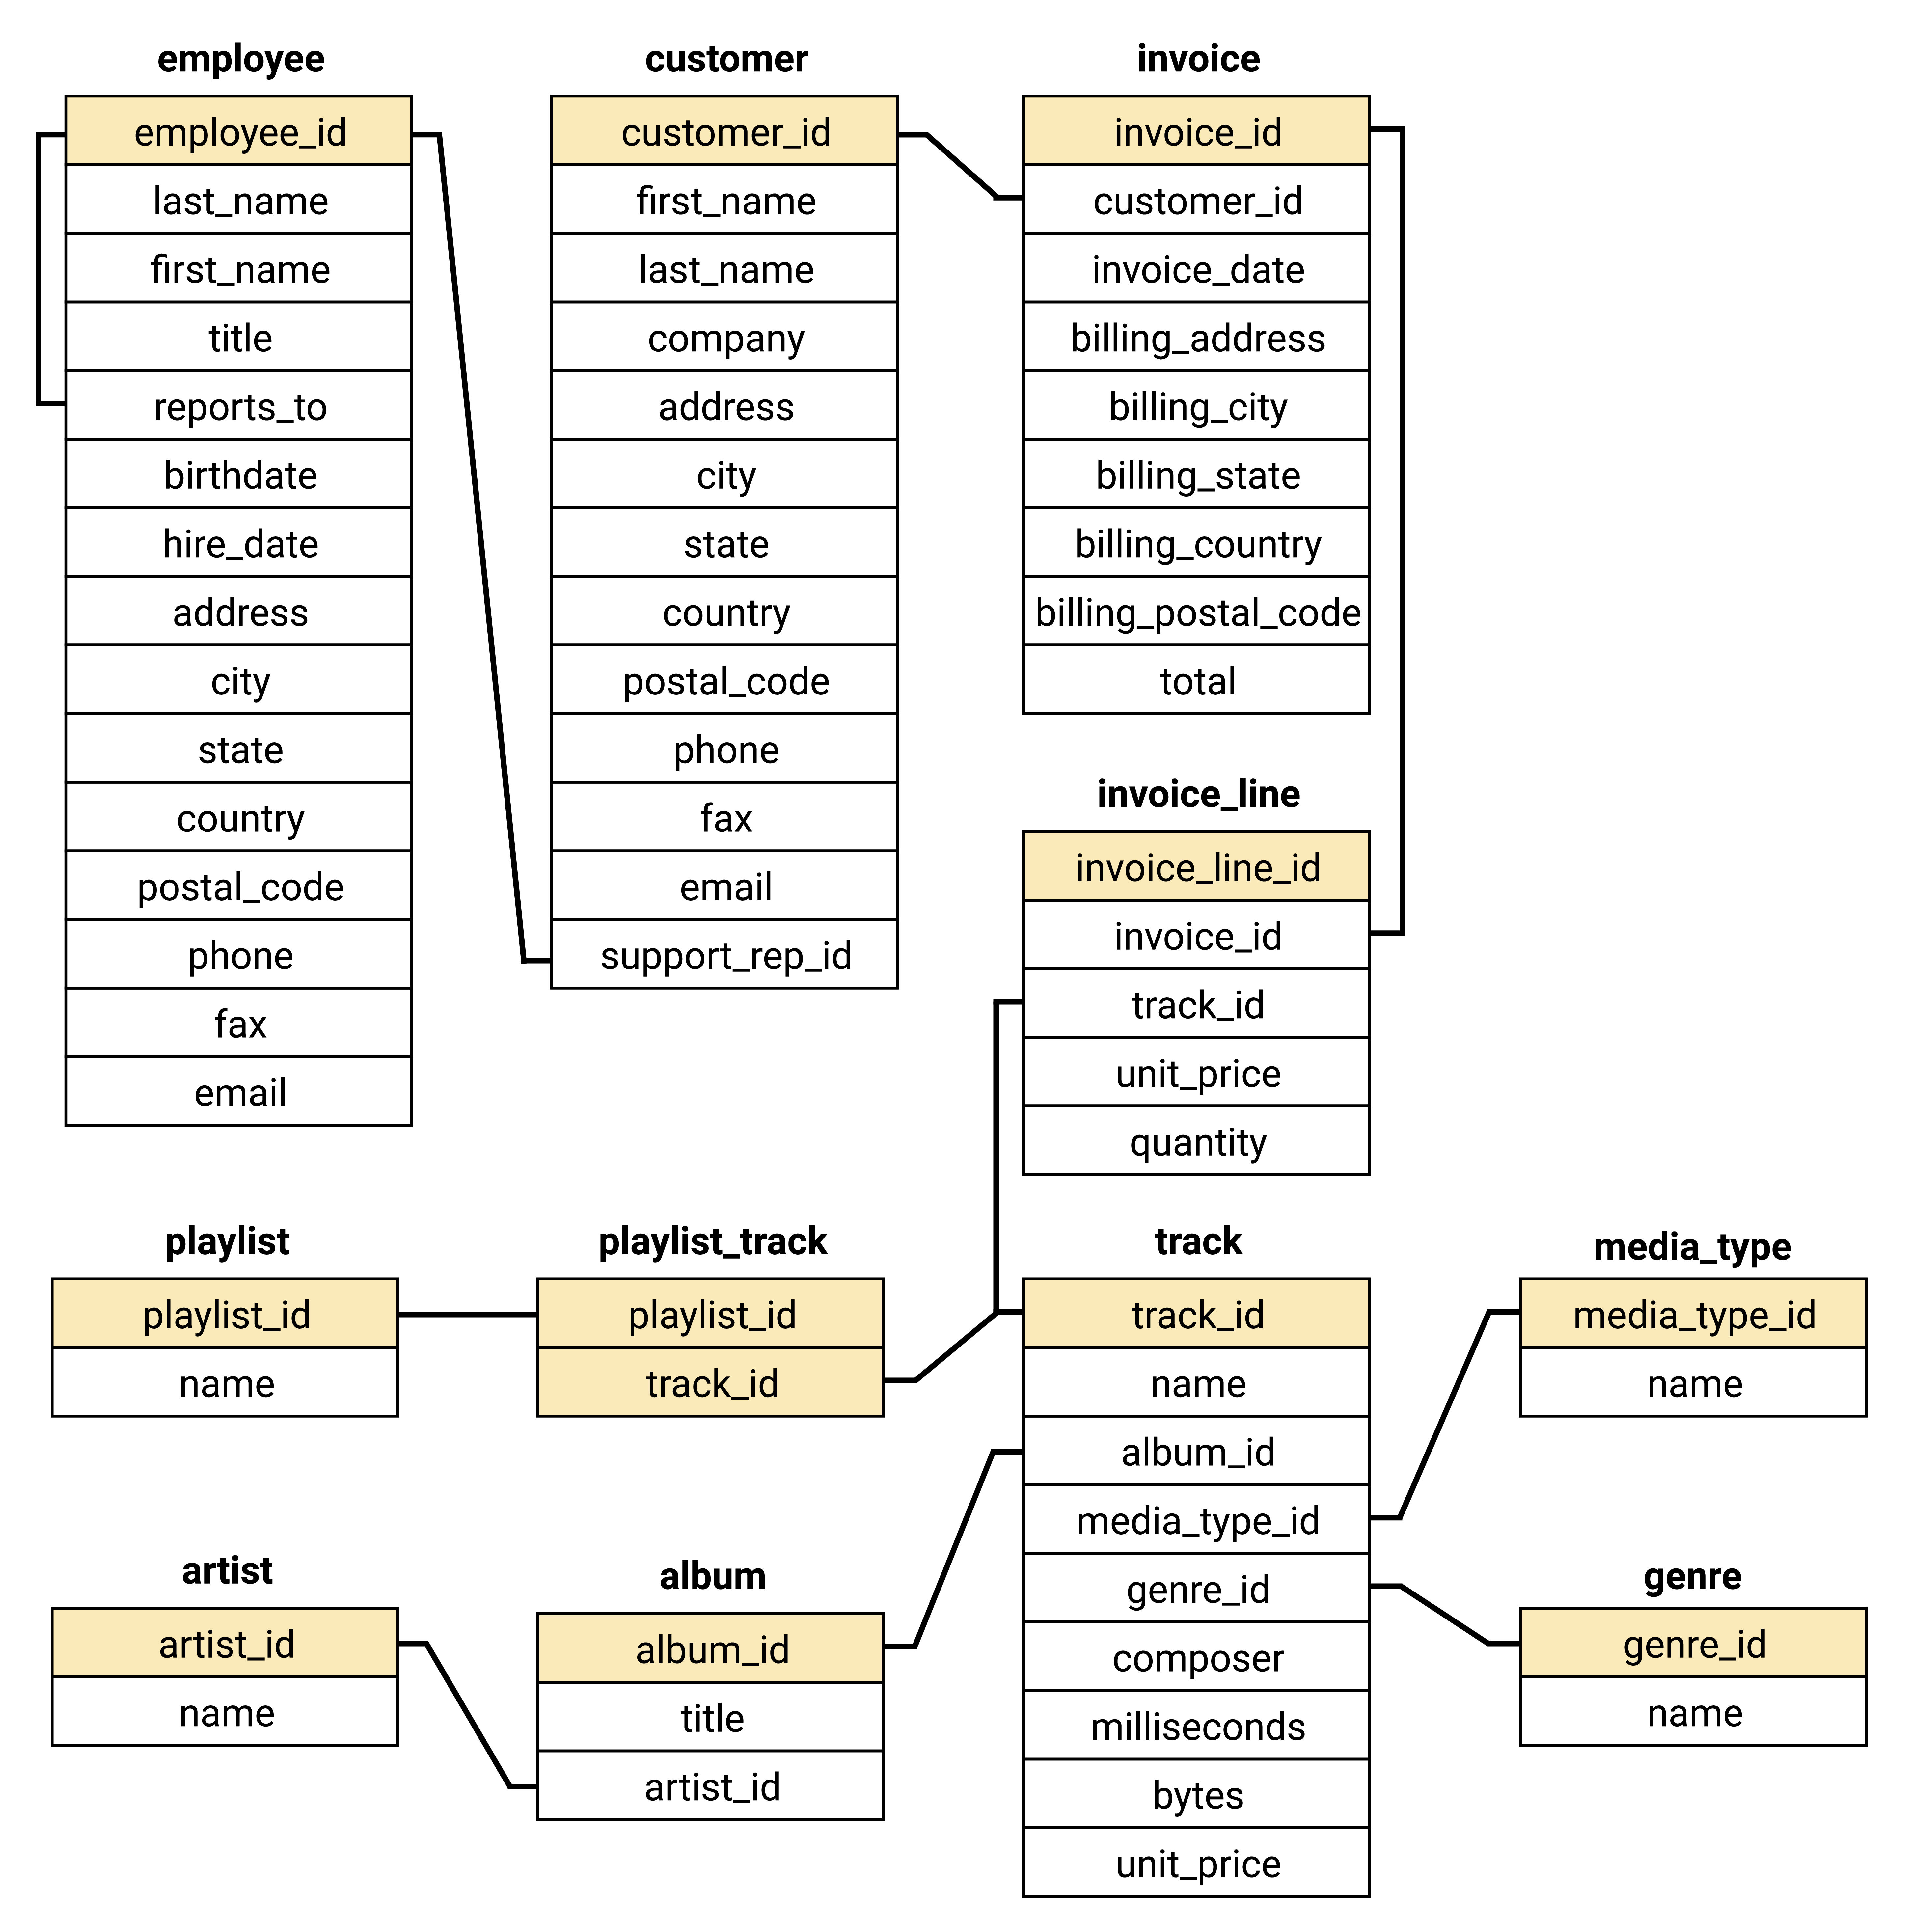

In [2]:
# displaying chinook database schema
from IPython.display import Image 
Image(filename = "E:\Jupyter\Python Learning files\SQL\chinook-schema.jpg", width=800)

## Question 1: Selecting New Albums to Purchase

We have been presented with the follwing four albums and we need to decide which albums we should sign. WE have room for two only.

|Artist Name |Genre |
|:---:|:---:|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|POP|
|Slim Jim Bites|Blues|

To answer this we need to know which genre sells more albums ?

In [3]:
# joining genre, track & invoice_line 
albums_to_purchase = '''
WITH 
track_genre AS 
(SELECT 
t.track_id, 
t.name track_name, 
g.name genre_name 
FROM track t 
LEFT JOIN genre g ON g.genre_id = t.genre_id), 

inv_track_genre AS 

(SELECT 
* 
FROM track_genre tg 
INNER JOIN invoice_line il ON il.track_id = tg.track_id 
INNER JOIN invoice i ON i.invoice_id = il.invoice_id 
WHERE billing_country = 'USA'
)

SELECT genre_name genre, COUNT(quantity) tracks_sold, CAST(COUNT(quantity) AS FLOAT)/
(SELECT COUNT(*) FROM inv_track_genre) percentage_sold 
FROM inv_track_genre 
GROUP BY 1 
ORDER BY 2 DESC 
limit 10'''
genre_sales_us = run_query(albums_to_purchase)
genre_sales_us

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


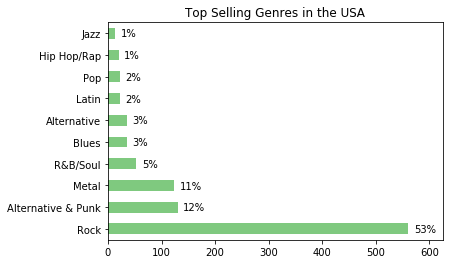

In [4]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the result on the plot above, the two ablums to be signed will be the following:

|Rank|Artist Name |Genre |
|:---:|:---:|:---:|
|1|Red Tone|Punk|
|2|Slim Jim Bites|Blues|


In [5]:
q = '''SELECT invoice_id, SUM(unit_price) FROM invoice_line GROUP BY invoice_id'''
run_query(q)

,invoice_id,SUM(unit_price)
0,1,15.84
1,2,9.90
2,3,1.98
3,4,7.92
4,5,16.83
...,...,...
609,610,6.93
610,611,1.98
611,612,11.88
612,613,8.91


In [6]:
q = '''SELECT
t.album_id, il.invoice_id, SUM(il.unit_price) FROM track t 
INNER JOIN invoice_line il ON il.track_id = t.track_id
GROUP BY il.invoice_id'''
run_query(q)

,album_id,invoice_id,SUM(il.unit_price)
0,91,1,15.84
1,322,2,9.90
2,203,3,1.98
3,314,4,7.92
4,163,5,16.83
...,...,...,...
609,83,610,6.93
610,215,611,1.98
611,182,612,11.88
612,153,613,8.91


In [7]:
q = '''SELECT
t.album_id, il.invoice_id, SUM(il.unit_price) FROM track t 
INNER JOIN invoice_line il ON il.track_id = t.track_id
GROUP BY t.album_id'''
run_query(q)

,album_id,invoice_id,SUM(il.unit_price)
0,1,23,73.26
1,2,106,2.97
2,3,579,5.94
3,4,77,49.50
4,5,142,79.20
...,...,...,...
246,325,586,0.99
247,329,111,0.99
248,336,59,0.99
249,339,134,7.92


## 2. Which sales support employee have more sales ?

In [8]:
employee_sales_performance = '''
SELECT e.first_name||' '||e.last_name support_employee, e.hire_date, SUM(i.total) total_sales FROM invoice i 
INNER JOIN customer c ON c.customer_id = i.customer_id 
INNER JOIN employee e ON e.employee_id = c.support_rep_id 
GROUP BY c.support_rep_id
'''
run_query(employee_sales_performance)

,support_employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


Text(0, 0.5, '')

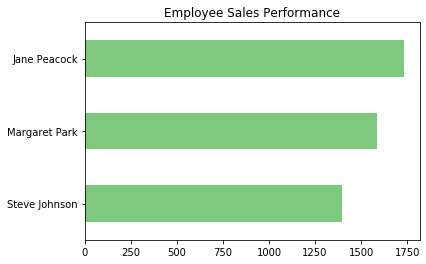

In [9]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index('support_employee', drop=True, inplace=True)
employee_sales.sort_values('total_sales', inplace=True)
employee_sales['total_sales'].plot.barh(title="Employee Sales Performance",
    colormap=plt.cm.Accent)
plt.ylabel('')

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## 3. Who are the most spending customers ?

In [10]:
q = '''
SELECT
   c.first_name || " " || c.last_name customer_name,
   COUNT(i.invoice_id) number_of_purchases,
   SUM(i.total) total_spent   
FROM invoice i
INNER JOIN customer c ON i.customer_id = c.customer_id
GROUP BY 1 ORDER BY 3 desc limit 10'''
run_query(q)

,customer_name,number_of_purchases,total_spent
0,František Wichterlová,18,144.54
1,Helena Holý,12,128.70
2,Hugh O'Reilly,13,114.84
3,Manoj Pareek,13,111.87
4,Luís Gonçalves,13,108.90
5,Fernanda Ramos,15,106.92
6,João Fernandes,13,102.96
7,François Tremblay,9,99.99
8,Wyatt Girard,11,99.99
9,Enrique Muñoz,11,98.01


## 4. Which total purchasing range has most customers ?

We will catogeraize the cusomers into three categories `big spender` who spent more than `100 $`, `small spender` who spent between `100 $` & `40 $` and `regular` who spent less than `40 $`

In [11]:
q = '''
with cust_catogery as (
SELECT
   c.first_name || " " || c.last_name customer_name,
   COUNT(i.invoice_id) number_of_purchases,
   SUM(i.total) total_spent,
   CASE
       WHEN sum(i.total) < 40 THEN 'small spender'
       WHEN sum(i.total) > 100 THEN 'big spender'
       ELSE 'regular'
       END
       AS customer_category
FROM invoice i
INNER JOIN customer c ON i.customer_id = c.customer_id
GROUP BY 1 ORDER BY 1)
SELECT customer_category, count(customer_category) no_customers from cust_catogery group by 1 
'''
customer_category = run_query(q)
customer_category

,customer_category,no_customers
0,big spender,7
1,regular,49
2,small spender,3


In [12]:
customer_category.set_index("customer_category", drop=True, inplace=True)

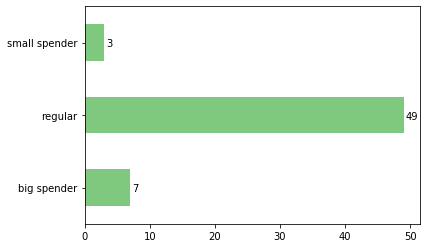

In [13]:
customer_category.plot.barh(legend=False, colormap=plt.cm.Accent)
plt.ylabel('')
for i, label in enumerate(list(customer_category.index)):
    score = customer_category.loc[label, "no_customers"]
    plt.annotate(score, (score + .3, i - 0.05))
plt.show()    

## 5. Which country most custmers come from and what is aveage amount spent by custmer

In [14]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(customer_id)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    )
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


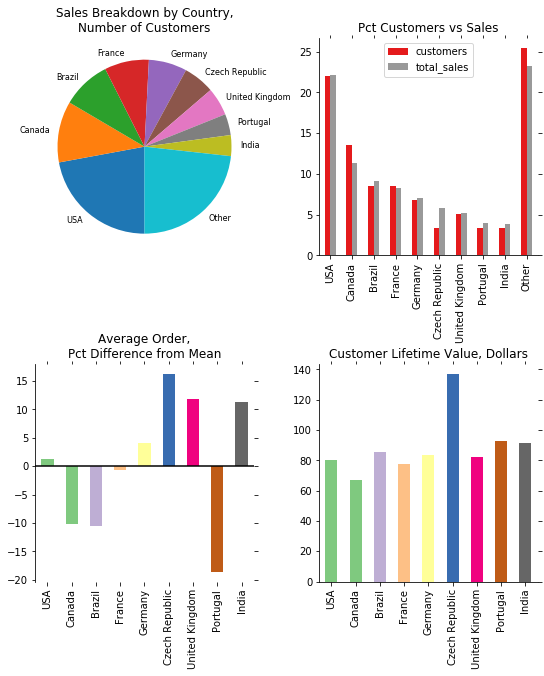

In [15]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()


Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's look like we have a shortlist of the countries that we might consider for future overseas expnsion. But it's worth keeping in mind that because the amount of data from each of these countries is relatively low, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence.

## What is type of purchase occured most in term of albums purchases vs tracks purchases

In [16]:
q = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

albums_vs_tracks = run_query(q)
albums_vs_tracks

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


In [17]:
albums_vs_tracks = albums_vs_tracks.set_index('album_purchase')

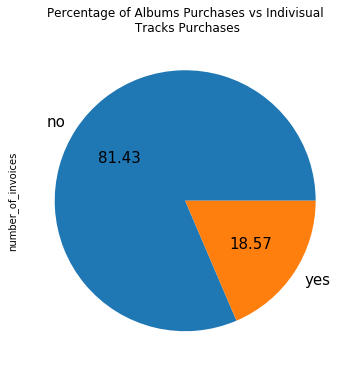

In [18]:
fig, ax = plt.subplots(facecolor='white', figsize=(6,6))

albums_vs_tracks['number_of_invoices'].plot.pie(
    ax=ax,
    title='Percentage of Albums Purchases vs Indivisual\n Tracks Purchases',
    fontsize=15,
    autopct='%.2f'
)